🎯 Top-3 Scoreline Accuracy: 24.24%
🎯 Scoreline Accuracy: 6.06%
              precision    recall  f1-score   support

         0-0       0.00      0.00      0.00         3
         0-1       0.00      0.00      0.00         5
         0-2       0.00      0.00      0.00         6
         0-3       0.00      0.00      0.00         3
         1-0       0.00      0.00      0.00         6
         1-1       0.00      0.00      0.00         9
         1-2       0.00      0.00      0.00         6
         1-3       0.00      0.00      0.00         2
         2-0       0.00      0.00      0.00         4
         2-1       0.11      0.14      0.12         7
         2-2       0.27      0.50      0.35         6
         3-0       0.00      0.00      0.00         2
         3-1       0.00      0.00      0.00         3
         3-2       0.00      0.00      0.00         2
         4-1       0.00      0.00      0.00         2

    accuracy                           0.06        66
   macro avg     

/Users/rafay/Desktop/pl-predictor/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rafay/Desktop/pl-predictor/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rafay/Desktop/pl-predictor/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

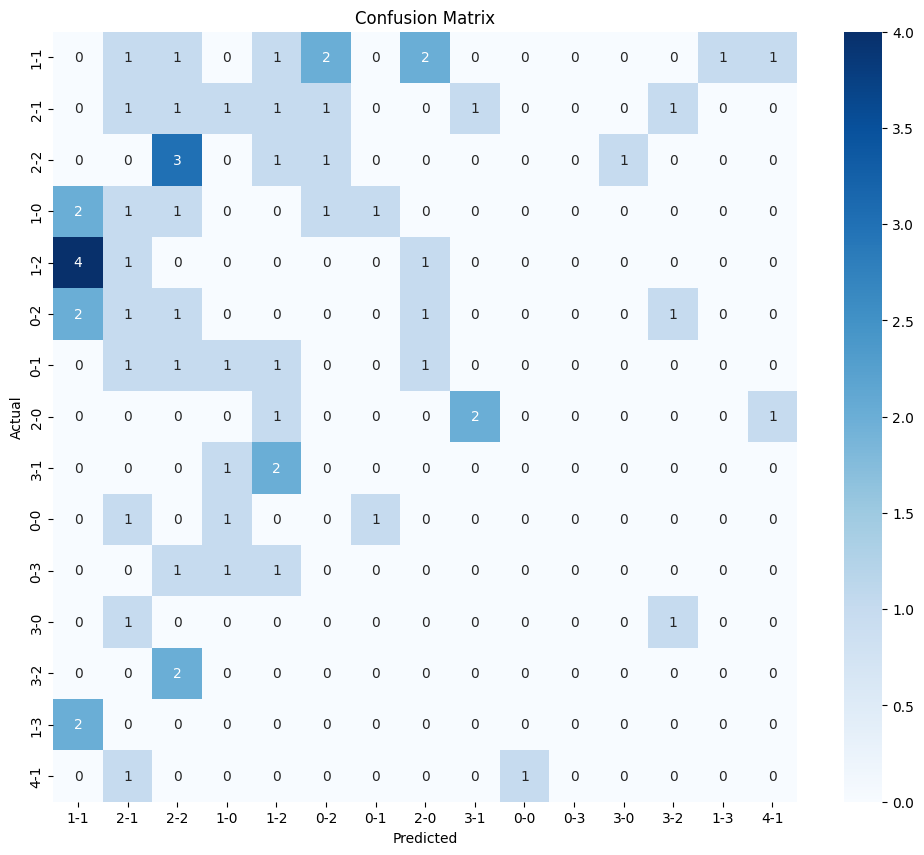

In [ ]:
# 📦 Imports
import pandas as pd
import numpy as np
import sys
sys.path.append("../src")

from data.features import add_rolling_stats, add_recent_form_score, add_goal_diff_form
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned match data
df = pd.read_csv("../data/processed/cleaned_matches.csv")

# Apply features
df = add_rolling_stats(df)
df = add_recent_form_score(df)
df = add_goal_diff_form(df)

# Encode team names
teams = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()
team_to_id = {team: idx for idx, team in enumerate(teams)}
df['HomeTeamID'] = df['HomeTeam'].map(team_to_id)
df['AwayTeamID'] = df['AwayTeam'].map(team_to_id)

# Create scoreline label
df['Scoreline'] = df['HomeGoals'].astype(str) + '-' + df['AwayGoals'].astype(str)

# Keep only most common scorelines (top 30)
top_scorelines = df['Scoreline'].value_counts().head(15).index
df = df[df['Scoreline'].isin(top_scorelines)]

# Define features and target
feature_cols = [
    'HomeTeamID', 'AwayTeamID',
    'HomeAvgGF', 'HomeAvgGA',
    'AwayAvgGF', 'AwayAvgGA',
    'HomeFormScore', 'AwayFormScore',
    'HomeGDForm', 'AwayGDForm'
]
X = df[feature_cols]
y = df['Scoreline']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Train RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Top-3 prediction accuracy
probs = clf.predict_proba(X_test)
top_classes = clf.classes_  # same order as columns in probs

# For each prediction, check if true label is in top 3 predicted classes
correct_top3 = 0
for i, true_label in enumerate(y_test):
    top3_indices = np.argsort(probs[i])[::-1][:3]
    top3_labels = top_classes[top3_indices]
    if true_label in top3_labels:
        correct_top3 += 1

top3_accuracy = correct_top3 / len(y_test)
print(f"Top-3 Scoreline Accuracy: {top3_accuracy:.2%}")


# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Scoreline Accuracy: {accuracy:.2%}")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix (visual)
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred, labels=top_scorelines)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=top_scorelines, yticklabels=top_scorelines, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()